In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import re
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import tensorflow as tf

In [2]:
# Load and preprocess the dataset
df = pd.read_csv('/content/labeled_data.csv')

# Ensure labels are binary (0 or 1)
df = df[df['class'].isin([0, 1])]

df['tweet'] = df['tweet'].apply(lambda x: x.lower())
punctuation_signs = list("?:!.,;")
for punct_sign in punctuation_signs:
    df['tweet'] = df['tweet'].str.replace(re.escape(punct_sign), '', regex=True)
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ' '))
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ' '))
df['tweet'] = df['tweet'].str.replace("    ", " ")
df['tweet'] = df['tweet'].str.replace('"', '')
df['tweet'] = df['tweet'].str.replace("'s", "")
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['tweet'] = df['tweet'].str.replace(regex_stopword, '', regex=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['class'], test_size=0.2, random_state=42)

# Tokenize the text
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

# Define the hybrid RNN model
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(max_words, 100)(input_layer)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
gru_layer = Bidirectional(GRU(128, return_sequences=True))(lstm_layer)
gru_layer = GRU(128)(gru_layer)
dense_layer = Dense(64, activation='relu')(gru_layer)
batch_norm_layer = BatchNormalization()(dense_layer)
dropout_layer = Dropout(0.5)(batch_norm_layer)
dense_layer_2 = Dense(32, activation='relu')(dropout_layer)
batch_norm_layer_2 = BatchNormalization()(dense_layer_2)
dropout_layer_2 = Dropout(0.5)(batch_norm_layer_2)
output_layer = Dense(1, activation='sigmoid')(dropout_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Add class weights to handle class imbalance (if necessary)
class_weights = {0: 1.0, 1: 1.0}  # Adjust these weights based on your dataset

# Add checkpoints and early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=callbacks, class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/10
464/464 [==============================] - 417s 875ms/step - loss: 0.6605 - accuracy: 0.6850 - val_loss: 0.2498 - val_accuracy: 0.9388
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


464/464 [==============================] - 370s 797ms/step - loss: 0.3553 - accuracy: 0.8783 - val_loss: 0.2018 - val_accuracy: 0.9382
Epoch 3/10
464/464 [==============================] - 365s 786ms/step - loss: 0.2651 - accuracy: 0.9138 - val_loss: 0.1874 - val_accuracy: 0.9394
Epoch 4/10
464/464 [==============================] - 366s 789ms/step - loss: 0.2158 - accuracy: 0.9286 - val_loss: 0.2050 - val_accuracy: 0.9267
Epoch 5/10
464/464 [==============================] - 361s 779ms/step - loss: 0.1795 - accuracy: 0.9347 - val_loss: 0.2127 - val_accuracy: 0.9394
Epoch 6/10
464/464 [==============================] - 356s 768ms/step - loss: 0.1430 - accuracy: 0.9483 - val_loss: 0.2993 - val_accuracy: 0.9127
Epoch 7/10
464/464 [==============================] - 368s 794ms/step - loss: 0.1197 - accuracy: 0.9585 - val_loss: 0.4534 - val_accuracy: 0.8939
Epoch 8/10
129/129 [==============================] - 27s 211ms/step - loss: 0.1849 - accuracy: 0.9396
Test Accuracy: 0.939621746540069

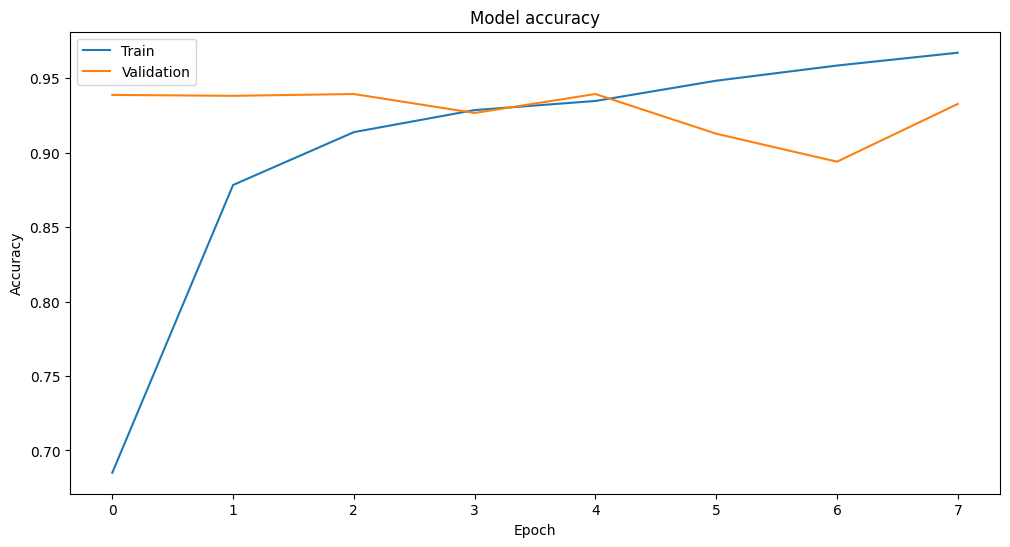

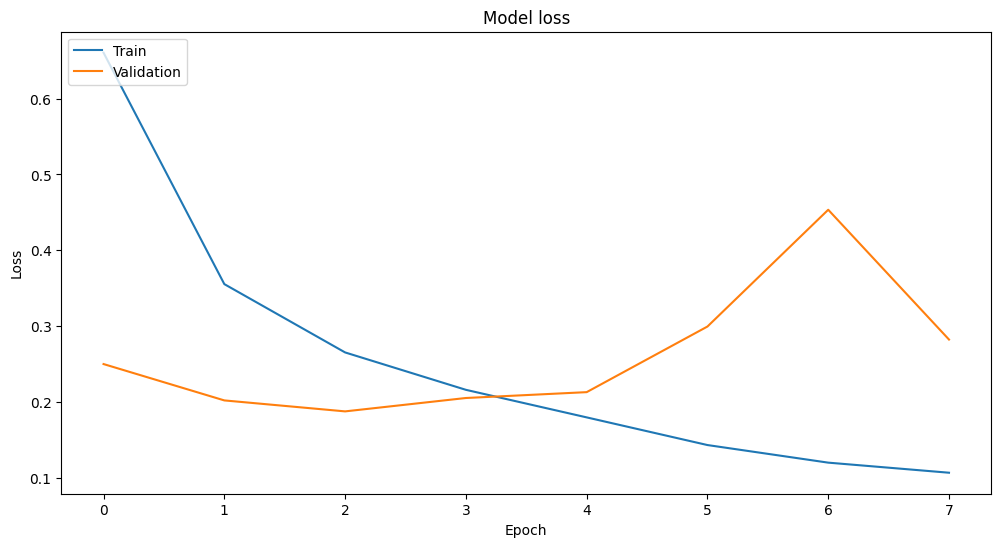

129/129 [==============================] - 29s 205ms/step


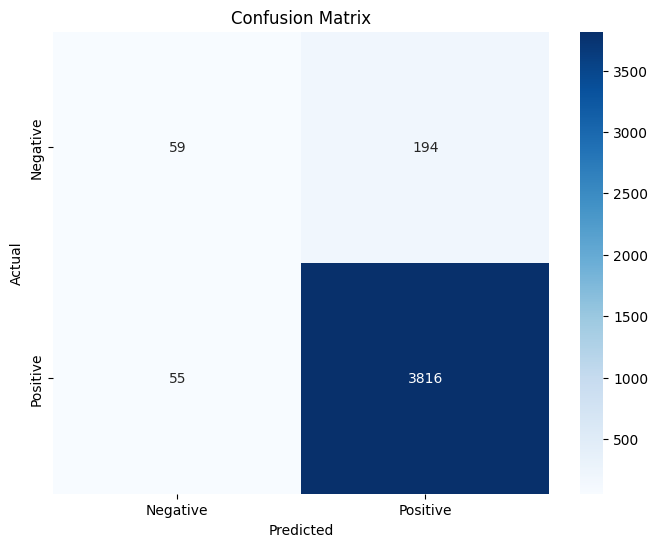

              precision    recall  f1-score   support

    Negative       0.52      0.23      0.32       253
    Positive       0.95      0.99      0.97      3871

    accuracy                           0.94      4124
   macro avg       0.73      0.61      0.64      4124
weighted avg       0.92      0.94      0.93      4124

129/129 [==============================] - 29s 225ms/step


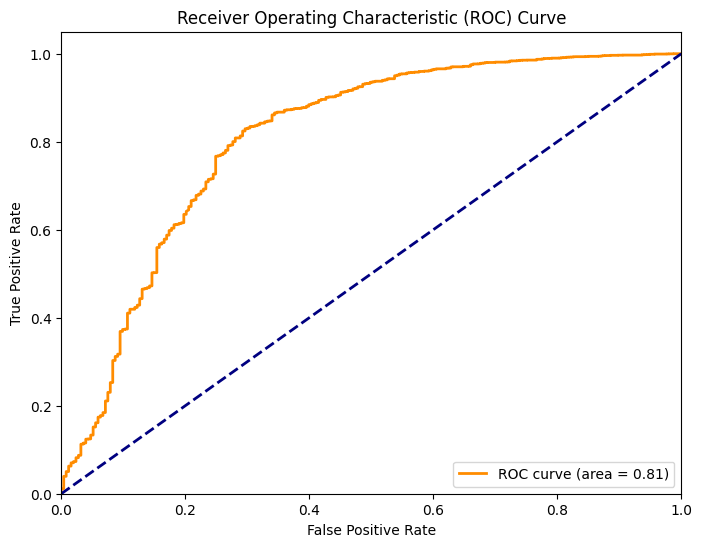

In [4]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test_pad))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()